# ECE4782 Deep Learning Labs
## 2. Convolutional Neural Network

In this chapter, we will learn how to implement a convolutional neural network by using PyTorch.

#### 0. Prepare Data

We will use the dataset originally from [Epileptic Seizure Recognition Data Set](http://archive.ics.uci.edu/ml/datasets/Epileptic+Seizure+Recognition) at UCI Machine Learning Repository. Please refer to the following paper for the details:

*Andrzejak RG, Lehnertz K, Rieke C, Mormann F, David P, Elger CE (2001) Indications of nonlinear deterministic and finite dimensional structures in time series of brain electrical activity: Dependence on recording region and brain state, Phys. Rev. E, 64, 061907*

As the dataset is formatted in CSV form, we will use Pandas again.

In [1]:
import pandas as pd

df = pd.read_csv('seizure.csv')
df

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11495,X22.V1.114,-22,-22,-23,-26,-36,-42,-45,-42,-45,...,15,16,12,5,-1,-18,-37,-47,-48,2
11496,X19.V1.354,-47,-11,28,77,141,211,246,240,193,...,-65,-33,-7,14,27,48,77,117,170,1
11497,X8.V1.28,14,6,-13,-16,10,26,27,-9,4,...,-65,-48,-61,-62,-67,-30,-2,-1,-8,5
11498,X10.V1.932,-40,-25,-9,-12,-2,12,7,19,22,...,121,135,148,143,116,86,68,59,55,3


As it is decribed in their web page, each row is a subject or a patient record randomly extracted for 1 min.
We will shift each `y` value, because they are ranged from 1 to 5.

In [2]:
labels = df['y'].values
labels

array([4, 1, 5, ..., 5, 3, 4])

In [3]:
labels = labels - 1
labels

array([3, 0, 4, ..., 4, 2, 3])

In [4]:
labels.shape

(11500,)

Extract signal data also.

In [5]:
data = df.loc[:, 'X1':'X178'].values
data

array([[ 135,  190,  229, ..., -116,  -83,  -51],
       [ 386,  382,  356, ...,  154,  143,  129],
       [ -32,  -39,  -47, ...,  -35,  -35,  -36],
       ...,
       [  14,    6,  -13, ...,   -2,   -1,   -8],
       [ -40,  -25,   -9, ...,   68,   59,   55],
       [  29,   41,   57, ...,   -2,    2,   20]])

In [6]:
data.shape

(11500, 178)

Then, we will split the whole dataset into three subsets: train, validation, and test set. In practice, the amount of test set is chosen within 15~20% and the amount of validation set is chosen within 10~15%, but it is not limited unless they are too non-sense.

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=4782)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=4782)
print(X_train.shape, X_valid.shape, X_test.shape)
print(X_train.shape[0] + X_valid.shape[0] + X_test.shape[0])

(7360, 178) (1840, 178) (2300, 178)
11500


#### 1. Loading Datasets

In [8]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# lets fix the random seeds for reproducibility.
torch.manual_seed(4782)
if torch.cuda.is_available():
    torch.cuda.manual_seed(4782)

trainset = TensorDataset(torch.from_numpy(X_train.astype('float32')).unsqueeze(1), torch.from_numpy(y_train.astype('long')))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True, num_workers=2)

validset = TensorDataset(torch.from_numpy(X_valid.astype('float32')).unsqueeze(1), torch.from_numpy(y_valid.astype('long')))
validloader = torch.utils.data.DataLoader(validset, batch_size=10, shuffle=False, num_workers=2)

testset = TensorDataset(torch.from_numpy(X_test.astype('float32')).unsqueeze(1), torch.from_numpy(y_test.astype('long')))
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False, num_workers=2)

classes = ('Seizure', 'TumorArea', 'HealthyArea', 'EyesClosed', 'EyesOpen')

As usual, let's check a few data points.

In [9]:
# get some random training samples
dataiter = iter(trainloader)
X_samples, y_samples = dataiter.next()

print(X_samples)
print(y_samples)

tensor([[[  -4.,   -7.,  -12.,  ..., -145., -151., -154.]],

        [[  59.,  110.,  145.,  ..., -216., -140.,  -60.]],

        [[ -67.,  -57.,  -24.,  ...,  140.,  120.,   70.]],

        ...,

        [[ -17.,  -36.,  -52.,  ...,  -19.,   -1.,   -8.]],

        [[ 104.,   94.,   86.,  ...,  -26.,  -21.,   -5.]],

        [[ -46.,  -41.,  -37.,  ...,   30.,   33.,   25.]]])
tensor([1, 3, 3, 2, 3, 1, 4, 4, 3, 2])


#### 2. Define CNN class

We will define a model similar to what we did in the previous chapter.

A key module to construct a convolutional net is `nn.ConvXd`. Although we use 1-dimensional convolution layer for this tutorial, parameters are almost same for all X-dimensional convolution layers. You need to specify the number of input channels (`in_channels`), the number of output channels (`out_channels`), the kernel (filter) size (`kernel_size`), stride size (`stride`), zero-padding (`padding`), and so forth. If you are not familar with these terms, it is highly recommended to read introductory materials about CNN.

We will use 2 convolution layers with max pooling and they are followed by 3 fully-connected layers with ReLU activation. We do not apply any activation at the output layer to use activation-combined loss function for a better numerical stability.

In [10]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(6, 16, 5)
        self.fc1 = nn.Linear(in_features=16 * 41, out_features=128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 41)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = ConvNet()

Again, check some sample outputs to see if the model works (here 'work' means whether it gives output without error or not).
It outputs 5-dim vector as we expected for 10 input data as we passed, which seem correct. 

In [11]:
output = model(X_samples)
output

tensor([[-0.2363,  0.1675, -0.1934, -0.2931, -0.3070],
        [-3.0574,  1.0879,  1.8203,  0.6211,  0.4661],
        [ 0.6394,  2.2822,  2.4944, -2.4973,  2.0732],
        [-0.4217,  0.7080,  0.5946, -1.2929,  0.8273],
        [-0.0173,  1.4895,  1.4494, -1.0057,  0.6009],
        [ 1.1719,  1.0141,  1.5979,  0.3310,  0.9962],
        [-0.5927,  0.4274,  0.9012,  0.1375,  0.3392],
        [-1.2943,  0.7049,  0.1889, -0.9372,  0.2112],
        [-0.5430,  0.5389,  0.7414, -0.4429, -0.2226],
        [-0.6712,  1.0287,  0.7442,  0.6598,  0.8652]],
       grad_fn=<AddmmBackward>)

#### 3. Define a Loss function and optimizer

We use `CrossEntropyLoss` which combines LogSoftmax and Negative Log-likelihood loss function. **This is the reason why we did not apply activation function such as softmax after the output layer.**

On the other hand, we will use ADAM optimizer with its default parameters.

In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

#### 4. Train the network

Before we train the model, check first if GPU is available.

In [13]:
cuda = torch.cuda.is_available()
cuda

True

If GPU is available, we can move the model (all its parameter Tensors) onto GPU by simply calling `MODEL = MODEL.cuda()`

In [14]:
if cuda:
    model = model.cuda()

If we decided to use GPU and moved the model above, we also need to put all the data Tensors used in training epochs onto GPU. It can be done also in the same manner, simply calling `TENSOR.cuda()`.

The following training epochs are very similar to what we have seen in the previous chapter, especially from line 4 to 24. Here, we add a few more code lines to see the model performance on the validation set at each epoch. It is almost same with the training part: getting data from Loader (and move them onto GPU if needed) and passing them through the forward computation. We do not need (MUST NOT) to do backward computations (back-propagations) on the validation set.

`MODEL.train()` and `MODEL.eval()` are functions acting as a 'switch' which turns on/off any randomness of layers in the model. For example, if we use dropout in the model, we do not in this tutorial though (it is related with an exercise below), it means any connection between layers will be disconnected according to the keeping probability we set. However, this should be 'turned on' ONLY in the training process and should be 'turned off' on evaluation (inference) mode.

We also use a couple of list to track train/validation losses.

In [15]:
train_losses = []
valid_losses = []

for epoch in range(10):  # loop over the dataset multiple times

    # set the model as train mode
    model.train()
    train_loss = 0.0
    train_counter = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, targets = data

        if cuda:
            inputs, targets = inputs.cuda(), targets.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += (loss.item() * inputs.size(0))
        train_counter += inputs.size(0)

    train_losses.append(train_loss/train_counter)
    
    # switch to evaluation mode
    model.eval()
    valid_loss = 0.0
    valid_counter = 0
    with torch.no_grad():
        for i, data in enumerate(validloader, 0):
            # get the inputs
            inputs, targets = data

            if cuda:
                inputs, targets = inputs.cuda(), targets.cuda()

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            valid_loss += (loss.item() * inputs.size(0))
            valid_counter += inputs.size(0)
    
    valid_losses.append(valid_loss/valid_counter)
    
    print("epoch {}: train loss {}, validation loss {}".format(epoch, train_losses[-1], valid_losses[-1]))
    
print('Finished Training')


epoch 0: train loss 1.2498696024894067, validation loss 0.9708624977780425
epoch 1: train loss 0.8903541359240594, validation loss 0.8152755387127399
epoch 2: train loss 0.7064590580639956, validation loss 0.652288042737738
epoch 3: train loss 0.5874134579106517, validation loss 0.6537159393015115
epoch 4: train loss 0.48982739810953324, validation loss 0.6344438522811169
epoch 5: train loss 0.41053266636014957, validation loss 0.6907507308718303
epoch 6: train loss 0.3424930762728605, validation loss 0.6880690096675054
epoch 7: train loss 0.26919142744325497, validation loss 0.7233822639302715
epoch 8: train loss 0.1925231228051416, validation loss 0.8544235742529449
epoch 9: train loss 0.17762855683671977, validation loss 0.9692794479348738
Finished Training


Let's plot train/validation losses we tracked over the epochs.
For your interest, in Jupyter notebook, we can easily make a plot with `matplotlib` by calling a magic function `%matplotlib inline`, or `%matplotlib notebook` for interative plotting (we can also use `matplotlib.pyplot.ion` and `ioff` for Jupyter (IPython) >= 5.0 and matplotlib >= 2.0).

### Exercise: online plot?

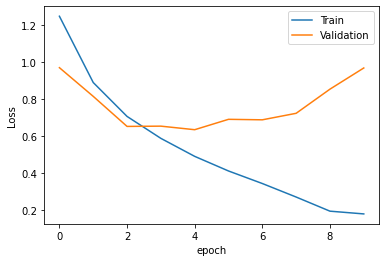

In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.figure()
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(valid_losses)), valid_losses, label='Validation')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(loc="best")

**What can you infer from this plot?**

#### 5. Test the network on the test data

We need to test the model on an unseen set, test set, if we finished training the model.

The procedure is same with validation in the training procedure except that we do not need iterations.

In [17]:
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
with torch.no_grad():
    for data in testloader:
        # get the inputs
        inputs, targets = data

        if cuda:
            inputs, targets = inputs.cuda(), targets.cuda()

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted == targets).squeeze()
        for i, label in enumerate(targets):
            class_correct[label] += c[i].item()
            class_total[label] += 1
    
for i in range(len(classes)):
    print('Accuracy of %s : %2d%% out of %d cases' % (classes[i], 100 * class_correct[i] / class_total[i], class_total[i]))

Accuracy of Seizure : 90% out of 497 cases
Accuracy of TumorArea : 56% out of 448 cases
Accuracy of HealthyArea : 61% out of 431 cases
Accuracy of EyesClosed : 69% out of 464 cases
Accuracy of EyesOpen : 77% out of 460 cases


Congratulations! We have completed the example of convolutional neural network!

We will see how we can use recurrent neural network also in the next chapter, and it will be very similar with the one in this chapter just with a differnt model class definition.

### Exercise 1. What can we infer from the loss plot above?

### Exercise 2. Try to run on CPU and compare the computation time? Is there a huge difference or not? Why?

### Exercise 3. Modify the network or the training procedure to improve the performance. 

### Exercise 4. Since the class 1 (Epileptic seizure) is the one we mostly care about, try to convert the problem into binary (class 1 vs rest) classification. Then, train and test the network to see the performce on binary setting.